## Correlation between month - lat - temp (air)

#### Import packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from numpy.linalg import inv

In [23]:
## Load the dataset
df = pd.read_csv('Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication.csv')
df.head()

,Ship,date,Latitude,Longitude,Temp (air),Temp (sea),mBar,Weather,Wind,Strength (Wind),...,Humpback Whale,Sperm Whales,Sei Whale,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Solglimt,10/23/1932,-54.100,5.100,NaN,NaN,979.0,l,N,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Solglimt,10/24/1932,-53.583,4.800,NaN,NaN,986.0,d,NW,4.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Solglimt,10/25/1932,-53.300,4.000,NaN,NaN,993.0,d,NW,4.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Solglimt,10/26/1932,-53.617,3.600,NaN,NaN,994.0,c,WSW,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Solglimt,10/27/1932,-53.400,3.333,NaN,NaN,1018.0,d,WNW,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
dlta = df[['date', 'Latitude', 'Temp (air)']].copy()
dlta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6281 entries, 0 to 6280
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        6281 non-null   object 
 1   Latitude    6281 non-null   float64
 2   Temp (air)  6133 non-null   float64
dtypes: float64(2), object(1)
memory usage: 147.3+ KB


In [25]:
dlta.dropna(inplace=True)
dlta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6133 entries, 148 to 6280
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        6133 non-null   object 
 1   Latitude    6133 non-null   float64
 2   Temp (air)  6133 non-null   float64
dtypes: float64(2), object(1)
memory usage: 191.7+ KB


In [27]:
# Center month around its mean so intercept is interpretable
dlta['month'] = pd.to_datetime(dlta['date']).dt.month
dlta['month_c'] = dlta['month'] - dlta['month'].mean()

In [28]:
# Prepare design matrix with intercept

X = dlta[['month_c', 'Latitude']].values
n_samples, n_features = X.shape
X_design = np.hstack((np.ones((n_samples, 1)), X))

y = dlta['Temp (air)'].values.reshape(-1, 1)


In [30]:
#Fit linear regression via sklearn
model = LinearRegression(fit_intercept=False)  # intercept included in X_design
model.fit(X_design, y)


LinearRegression(fit_intercept=False)

In [33]:
# Extract coefficients
coeffs = model.coef_.ravel()
intercept, coef_month_c, coef_lat = coeffs[0], coeffs[1], coeffs[2]

# Predictions and residuals
y_pred = model.predict(X_design)
residuals = y - y_pred

# Metrics: R², MSE, RMSE
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

#  Residual standard error (σ̂)
df_resid = n_samples - (n_features + 1)
sigma2 = (residuals**2).sum() / df_resid
rse = np.sqrt(sigma2)

# Variance–Covariance matrix of coefficients
cov_beta = sigma2 * inv(X_design.T @ X_design)
stderr = np.sqrt(np.diag(cov_beta))

In [34]:
# Print summary
print(f"Intercept: {intercept:.3f}")
print(f"Coefficient (month centered): {coef_month_c:.4f}")
print(f"Coefficient (latitude): {coef_lat:.4f}")
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.3f} °C")
print(f"Residual Standard Error = {rse:.3f} °C")
print("\nStandard errors of coefficients:")
print(f"  intercept: {stderr[0]:.4f}")
print(f"  month_c  : {stderr[1]:.4f}")
print(f"  latitude : {stderr[2]:.4f}")

Intercept: 21.108
Coefficient (month centered): -0.0691
Coefficient (latitude): 0.3435
R² = 0.615
RMSE = 1.904 °C
Residual Standard Error = 1.904 °C

Standard errors of coefficients:
  intercept: 0.2118
  month_c  : 0.0054
  latitude : 0.0035


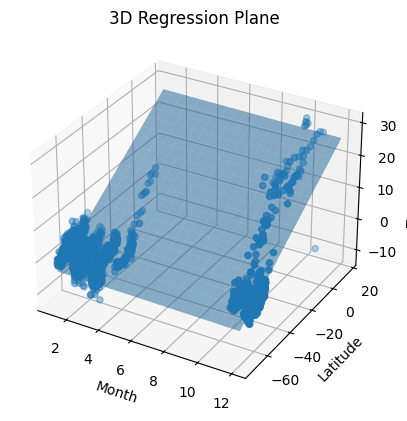

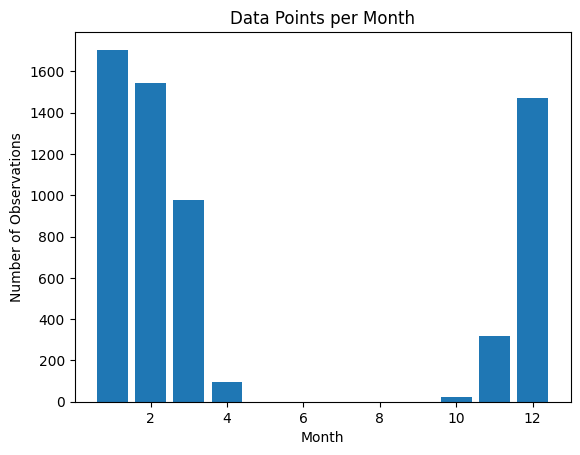

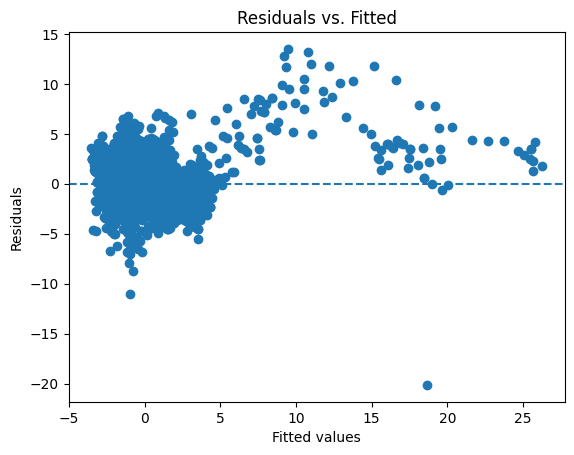

In [38]:
# 9. Visualization

# 9a. 3D scatter and regression plane
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dlta['month'], dlta['Latitude'], dlta['Temp (air)'])

# create prediction grid
month_grid = np.linspace(dlta['month'].min(), dlta['month'].max(), 20)
lat_grid   = np.linspace(dlta['Latitude'].min(), dlta['Latitude'].max(), 20)
M_grid, L_grid = np.meshgrid(month_grid, lat_grid)
M_c_grid = M_grid - dlta['month'].mean()

# predict grid
Xg = np.column_stack((np.ones(M_grid.size), M_c_grid.ravel(), L_grid.ravel()))
Z_grid = model.predict(Xg).reshape(M_grid.shape)

ax.plot_surface(M_grid, L_grid, Z_grid, alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Latitude')
ax.set_zlabel('Temperature')
plt.title('3D Regression Plane')
plt.show()

# 9b. Bar chart of counts per month
plt.figure()
counts = dlta['month'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Observations')
plt.title('Data Points per Month')
plt.show()

# 9c. Residuals vs. fitted values
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()